In [14]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import sys
import math
import copy
import glob

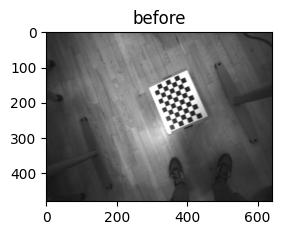

In [15]:
##
# constant parameters
# 最外面一圈的格子不算
nb_horizontal = 9
nb_vertical = 6
# world coordinates中，x先变化，然后是y，z全为0
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32) # set x and y coordinates
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2) # set z coordinates

##
# first read images, then extract image points 
left = glob.glob("imgs/left*.png")
right = glob.glob("imgs/right*.png")
imgpl = []
imgpr = []
img_left = []
img_right = []
objpoints = []

for i in range(len(left)):
    iml = cv2.imread(left[i])
    imr = cv2.imread(right[i])
    retl, corners_l = cv2.findChessboardCorners(iml,(nb_vertical,nb_horizontal))
    retr, corners_r = cv2.findChessboardCorners(imr,(nb_vertical,nb_horizontal))
    imgl = copy.deepcopy(iml)
    imgr = copy.deepcopy(imr)
    cv2.drawChessboardCorners(imgl, (nb_vertical,nb_horizontal), corners_l, retl)
    cv2.drawChessboardCorners(imgr, (nb_vertical,nb_horizontal), corners_r, retr)
    if retl and retr: # only when both of the images in a pair has the corners
        imgpl.append(corners_l)
        imgpr.append(corners_r)
        img_left.append(iml)
        img_right.append(imr)
        objpoints.append(objp)
    cv2.imshow('left', imgl)
    cv2.waitKey(5)
    cv2.imshow('right', imgr)
    cv2.waitKey(10)
cv2.destroyAllWindows()
gray = cv2.cvtColor(iml, cv2.COLOR_RGB2GRAY)
# determine the camera matirx 1
ret1, mtx1, dist1, rvecs1, tvecs1 = cv2.calibrateCamera(objpoints, imgpl, gray.shape[::-1], None, None)
gray = cv2.cvtColor(imr, cv2.COLOR_RGB2GRAY)
# determine the camera matirx 2
ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints, imgpr, gray.shape[::-1], None, None)

#undis_img_left = []
#undis_img_right = []
#for iml, imr in zip(img_left, img_right):
#    dst, mtx1 = undistort(iml, mtx1, dist1)
#    undis_img_left.append(dst)
#    dst, mtx2 = undistort(imr, mtx2, dist2)
#    undis_img_right.append(dst)
##
# undsitorted result
# take the first left image for example
plt.subplot(1,2,1)
plt.imshow(img_left[0])
plt.title('before')
#plt.subplot(1,2,2)
#plt.imshow(undis_img_left[0])
#plt.title('after')
plt.show()
# now we get the undistorted images


In [16]:
def undistort(img, mtx, dist):
    # rescale
    size = img.shape[:2]
    size = size[::-1]
    #newMtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, size,1,size)
    # undistort
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #x,y,w,h = roi
    #dst = dst[y:y+h,x:x+w]
    return dst, mtx

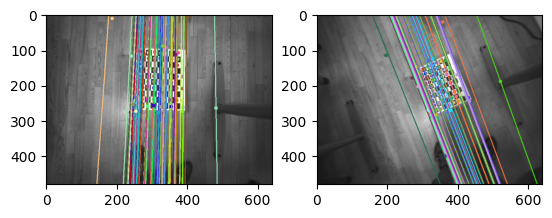

In [17]:
# draw epipolar lines
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        img1 = cv2.line(img1, (x0,y0),(x1,y1),color,2)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2
def calLines(iml, imr, numMatches=300, plot=False):
    iml = cv2.cvtColor(iml,cv2.COLOR_RGB2GRAY)
    imr = cv2.cvtColor(imr, cv2.COLOR_RGB2GRAY)
    #sift = cv2.xfeatures2d_SIFT.create()
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(iml, None)
    kp2, des2 = sift.detectAndCompute(imr, None)
    matcher = cv2.FlannBasedMatcher()
    match = matcher.match(des1, des2)
    # select the most relevant 300 matches
    match = sorted(match, key=lambda x:x.distance)
    good = []
    pts1 = []
    pts2 = []
    for m in match[:numMatches]:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)
    # select inlier points
    pts1 = pts1[mask.ravel() == 1]
    pts2 = pts2[mask.ravel() == 1]
    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2, F)
    lines1 = lines1.reshape(-1,3)
    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1, F)
    lines2 = lines2.reshape(-1,3)
    iml1, iml2 = drawlines(iml, imr, lines1, pts1, pts2)
    imr1, imr2 = drawlines(imr, iml, lines2, pts2, pts1)
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(iml1)
        plt.subplot(1,2,2)
        plt.imshow(imr1)
        plt.show()
# draw a pair of images(pair 15)
iml = img_left[1]
imr = img_right[1]
calLines(iml, imr, 300, True)

In [18]:
# use opencv built-in functions to do stereo rectification
# Before we have the undistorted images
ret, mtx1, dist1, mtx2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpl, imgpr, mtx1, dist1, mtx2, dist2, gray.shape[::-1], flags=cv2.CALIB_FIX_INTRINSIC)

In [19]:
def stereoRectify(iml, imr):
    R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(mtx1, dist1, mtx2, dist2, gray.shape[::-1],R, T)
    undis_img_sizel = iml.shape[:2]
    undis_img_sizel = undis_img_sizel[::-1]
    undis_img_sizer = imr.shape[:2]
    undis_img_sizer = undis_img_sizer[::-1]
    mapl1, mapl2 = cv2.initUndistortRectifyMap(mtx1, dist1, R1, P1, undis_img_sizel, cv2.CV_32FC1)
    mapr1, mapr2 = cv2.initUndistortRectifyMap(mtx2, dist2, R2, P2, undis_img_sizer, cv2.CV_32FC1)
    iml = cv2.remap(iml, mapl1, mapl2, cv2.INTER_LINEAR)
    imr = cv2.remap(imr, mapr1, mapr2, cv2.INTER_LINEAR)
    return iml, imr
rec_left = []
rec_right = []
for iml, imr in zip(img_left, img_right):
    iml, imr = stereoRectify(iml, imr)
    rec_left.append(iml)
    rec_right.append(imr)
# take 15 for example
calLines(rec_left[1], rec_right[1], 300, True)

error: OpenCV(4.6.0) /io/opencv/modules/calib3d/src/fundam.cpp:854: error: (-5:Bad argument) The input arrays should be 2D or 3D point sets in function 'findFundamentalMat'


In [ ]:
##
# try another dataset
##
#这个挑战的难度在于，我们得到的畸变系数其实是错的，明显看到它并不是单调的，所以之后的optimal new camera matrix和roi都是错的，roi是(0,0,0,0)，以至于我们裁剪之后，图片没了，会报错。怎么解决这个问题呢？我们要保证足够多的图片来算出正确的相机矩阵和畸变系数，而且这些图片必须拍摄的时候距离足够近。目前并没有其他方法能解决这个问题。
## 改参数

##
# constant parameters
# 最外面一圈的格子不算
nb_horizontal = 9
nb_vertical = 6
# world coordinates中，x先变化，然后是y，z全为0
objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32) # set x and y coordinates
objp[:,:2] = np.mgrid[0:nb_vertical,0:nb_horizontal].T.reshape(-1,2) # set z coordinates

##
# first read images, then extract image points 
left = glob.glob("mynteye/left*.png")
right = glob.glob("mynteye/right*.png")
imgpl = []
imgpr = []
img_left = []
img_right = []
objpoints = []
for i in range(len(left)):
    iml = cv2.imread(left[i])
    imr = cv2.imread(right[i])
    retl, corners_l = cv2.findChessboardCorners(iml,(nb_vertical,nb_horizontal))
    retr, corners_r = cv2.findChessboardCorners(imr,(nb_vertical,nb_horizontal))
    imgl = copy.deepcopy(iml)
    imgr = copy.deepcopy(imr)
    cv2.drawChessboardCorners(imgl, (nb_vertical,nb_horizontal), corners_l, retl)
    cv2.drawChessboardCorners(imgr, (nb_vertical,nb_horizontal), corners_r, retr)
    if retl and retr: # only when both of the images in a pair has the corners
        imgpl.append(corners_l)
        imgpr.append(corners_r)
        img_left.append(iml)
        img_right.append(imr)
        objpoints.append(objp)
    cv2.imshow('left', imgl)
    cv2.waitKey(5)
    cv2.imshow('right', imgr)
    cv2.waitKey(10)
cv2.destroyAllWindows()
gray = cv2.cvtColor(iml, cv2.COLOR_RGB2GRAY)
# determine the camera matirx 1
ret1, mtx1, dist1, rvecs1, tvecs1 = cv2.calibrateCamera(objpoints, imgpl, gray.shape[::-1], None, None)
gray = cv2.cvtColor(imr, cv2.COLOR_RGB2GRAY)
# determine the camera matirx 2
ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera(objpoints, imgpr, gray.shape[::-1], None, None)
# now we get the undistorted images

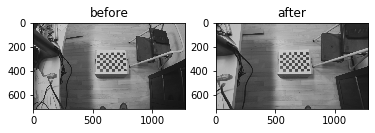

In [ ]:
undis_img_left = []
undis_img_right = []
for iml, imr in zip(img_left, img_right):
    dst, mtx1 = undistort(iml, mtx1, dist1)
    undis_img_left.append(dst)
    dst, mtx2 = undistort(imr, mtx2, dist2)
    undis_img_right.append(dst)
##
# undsitorted result
# take the first left image for example
plt.subplot(1,2,1)
plt.imshow(img_left[0])
plt.title('before')
plt.subplot(1,2,2)
plt.imshow(undis_img_left[0])
plt.title('after')
plt.show()

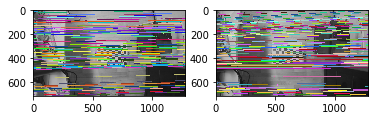

In [ ]:
# draw a pair of epipolar lines(pair 15)
iml = img_left[1]
imr = img_right[1]
calLines(iml, imr, 300, True)

In [ ]:
# use opencv built-in functions to do stereo rectification
flags = 0
flags |= cv2.CALIB_FIX_ASPECT_RATIO
flags |= cv2.CALIB_ZERO_TANGENT_DIST
flags |= cv2.CALIB_SAME_FOCAL_LENGTH
flags |= cv2.CALIB_RATIONAL_MODEL
flags |= cv2.CALIB_FIX_K3
flags |= cv2.CALIB_FIX_K4
flags |= cv2.CALIB_FIX_K5
term_crit = (cv2.TERM_CRITERIA_MAX_ITER+cv2.TERM_CRITERIA_EPS,100, 1e-5)
ret, mtx1, dist1, mtx2, dist2, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpl, imgpr, mtx1, dist1, mtx2, dist2, gray.shape[::-1], flags=flags, criteria=term_crit)

In [ ]:
rec_left = []
rec_right = []
for iml, imr in zip(img_left, img_right):
    iml, imr = stereoRectify(iml, imr)
    rec_left.append(iml)
    rec_right.append(imr)
# take 1 for example

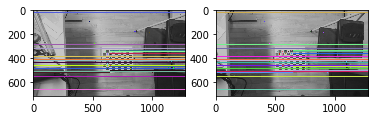

In [ ]:
calLines(rec_left[1], rec_right[1], 300, True)